In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/CS747_Assignment4/CS747_Assignment4


/content/drive/MyDrive/CS747_Assignment4/CS747_Assignment4


In [3]:
pip install Unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 20.5 MB/s eta 0:00:00


In [4]:
import os
import time
import math
import glob
import string
import random

import torch
import torch.nn as nn

from rnn.helpers import time_since

%matplotlib inline

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Language recognition with an RNN

If you've ever used an online translator you've probably seen a feature that automatically detects the input language. While this might be easy to do if you input unicode characters that are unique to one or a small group of languages (like "你好" or "γεια σας"), this problem is more challenging if the input only uses the available ASCII characters. In this case, something like "těší mě" would beome "tesi me" in the ascii form. This is a more challenging problem in which the language must be recognized purely by the pattern of characters rather than unique unicode characters.

We will train an RNN to solve this problem for a small set of languages thta can be converted to romanized ASCII form. For training data it would be ideal to have a large and varied dataset in different language styles. However, it is easy to find copies of the Bible which is a large text translated to different languages but in the same easily parsable format, so we will use 20 different copies of the Bible as training data. Using the same book for all of the different languages will hopefully prevent minor overfitting that might arise if we used different books for each language (fitting to common characteristics of the individual books rather than the language).

In [6]:
from unidecode import unidecode as unicodeToAscii

all_characters = string.printable
n_letters = len(all_characters)

print(unicodeToAscii('těší mě'))

tesi me


In [7]:
# Read a file and split into lines
def readFile(filename):
    data = open(filename, encoding='utf-8').read().strip()
    return unicodeToAscii(data)

def get_category_data(data_path):
    # Build the category_data dictionary, a list of names per language
    category_data = {}
    all_categories = []
    for filename in glob.glob(data_path):
        category = os.path.splitext(os.path.basename(filename))[0].split('_')[0]
        all_categories.append(category)
        data = readFile(filename)
        category_data[category] = data

    return category_data, all_categories

The original text is split into two parts, train and test, so that we can make sure that the model is not simply memorizing the train data.

In [8]:
train_data_path = 'language_data/train/*_train.txt'
test_data_path = 'language_data/test/*_test.txt'

train_category_data, all_categories = get_category_data(train_data_path)
test_category_data, test_all_categories = get_category_data(test_data_path)

n_languages = len(all_categories)

print(len(all_categories))
print(all_categories)

20
['french', 'english', 'romanian', 'lithuanian', 'vietnamese', 'swedish', 'italian', 'finnish', 'maori', 'xhosa', 'german', 'czech', 'portuguese', 'danish', 'albanian', 'turkish', 'esperanto', 'norwegian', 'hungarian', 'spanish']


# Data processing

In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1, dim=1)
    category_i = top_i[:, 0]
    return category_i

# Turn string into long tensor
def stringToTensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

def load_random_batch(text, chunk_len, batch_size, device):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, 1).long().to(device)
    input_text = []
    for i in range(batch_size):
        category = all_categories[random.randint(0, len(all_categories) - 1)]
        line_start = random.randint(0, len(text[category]) - chunk_len)
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
        line = text[category][line_start:line_start + chunk_len]
        input_text.append(line)
        input_data[i] = stringToTensor(line)
        target[i] = category_tensor
    return input_data, target, input_text


Implement Model
====================

For this classification task, we can use the same model we implement for the generation task which is located in `rnn/model.py`. See the `MP4_generation.ipynb` notebook for more instructions. In this case each output vector of our RNN will have the dimension of the number of possible languages (i.e. `n_languages`). We will use this vector to predict a distribution over the languages.

In the generation task, we used the output of the RNN at every time step to predict the next letter and our loss included the output from each of these predictions. However, in this task we use the output of the RNN at the end of the sequence to predict the language, so our loss function will use only the predicted output from the last time step.



# Train RNN

In [10]:
from rnn.model import RNN

In [11]:
chunk_len = 50

BATCH_SIZE = 100
n_epochs = 2000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'

criterion = nn.CrossEntropyLoss()
rnn = RNN(n_letters, hidden_size, n_languages, model_type=model_type, n_layers=n_layers).to(device)

**TODO:** Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and the next hidden layer representation. The cross entropy loss should be computed over the last RNN output scores from the end of the sequence and the target classification tensor. Lastly, call backward on the loss and take an optimizer step.

In [12]:
def train(rnn, target_tensor, data_tensor, optimizer, criterion, batch_size=BATCH_SIZE):
    """
    Train the model on a batch of data.

    Inputs:
    - rnn: model
    - target_tensor: target character data tensor of shape (batch_size, 1)
    - data_tensor: input character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    - batch_size: data batch size

    Returns:
    - output: output from RNN from the end of the sequence
    - loss: computed loss value as a Python float
    """
    # Initialize hidden state
    hidden = rnn.init_hidden(batch_size, device=device)
    optimizer.zero_grad()
    loss = 0

    # Loop over each character in the input sequence
    for c in range(data_tensor.size(1)):
        output, hidden = rnn(data_tensor[:, c], hidden)

    # Compute the loss only on the last output
    loss = criterion(output, target_tensor.squeeze())
    loss.backward()
    optimizer.step()

    return output, loss.item()


In [13]:
def evaluate(rnn, data_tensor, seq_len=chunk_len, batch_size=BATCH_SIZE):
    with torch.no_grad():
        data_tensor = data_tensor.to(device)
        hidden = rnn.init_hidden(batch_size, device=device)
        for i in range(seq_len):
            output, hidden = rnn(data_tensor[:,i], hidden)

        return output

def eval_test(rnn, category_tensor, data_tensor):
    with torch.no_grad():
        output = evaluate(rnn, data_tensor)
        loss = criterion(output, category_tensor.squeeze())
        return output, loss.item()

Training started with model: lstm, hidden_dim: 256, num_layers: 2, lr: 0.003
Step 1: Training Loss = 2.9968
Step 1: Test Loss = 2.8824
Step 2: Training Loss = 2.9891
Step 2: Test Loss = 2.8820
Step 3: Training Loss = 2.9572
Step 3: Test Loss = 2.8514
Step 4: Training Loss = 2.9341
Step 4: Test Loss = 2.7826
Step 5: Training Loss = 2.9194
Step 5: Test Loss = 2.7907
Step 6: Training Loss = 2.8252
Step 6: Test Loss = 2.6838
Step 7: Training Loss = 2.7602
Step 7: Test Loss = 2.6314
Step 8: Training Loss = 2.6601
Step 8: Test Loss = 2.5603
Step 9: Training Loss = 2.7172
Step 9: Test Loss = 2.5311
Step 10: Training Loss = 2.5442
Step 10: Test Loss = 2.5483
Step 11: Training Loss = 2.7422
Step 11: Test Loss = 2.4833
Step 12: Training Loss = 2.7036
Step 12: Test Loss = 2.6545
Step 13: Training Loss = 2.5242
Step 13: Test Loss = 2.3439
Step 14: Training Loss = 2.5666
Step 14: Test Loss = 2.4577
Step 15: Training Loss = 2.4948
Step 15: Test Loss = 2.3263
Step 16: Training Loss = 2.2925
Step 16: 

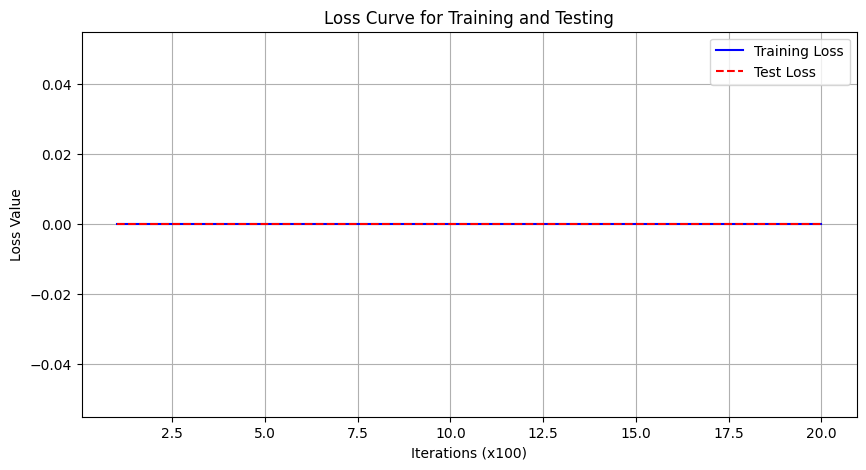

In [20]:
import torch
import time
import matplotlib.pyplot as plt

# Updated Hyperparameters
iterations = 2000
log_interval = 100
plot_interval = 100

hidden_dim = 256
num_layers = 2
lr = 0.003  # Slightly reduced learning rate
rnn_type = 'lstm'

# Initialize the RNN model, loss function, and optimizer
rnn = RNN(n_letters, hidden_dim, n_languages, model_type=rnn_type, n_layers=num_layers).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr, weight_decay=1e-6)  # Added small weight decay

# Lists to store losses for plotting
train_loss_total = 0.0
test_loss_total = 0.0
train_losses = []
test_losses = []

start_time = time.time()
correct_count = 0

print(f"Training started with model: {rnn_type}, hidden_dim: {hidden_dim}, num_layers: {num_layers}, lr: {lr}")

# Training loop
for step in range(1, iterations + 1):
    # Fetch a random batch of training data
    inputs, targets, text_batch = load_random_batch(train_category_data, chunk_len, BATCH_SIZE, device)

    # Training phase
    model_output, loss_value = train(rnn, targets, inputs, optimizer, loss_fn)
    train_loss_total += loss_value

    # Clip gradients to stabilize training
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=5.0)

    # Debug message for current loss
    print(f"Step {step}: Training Loss = {loss_value:.4f}")

    # Evaluation phase on test set
    _, test_loss_value = eval_test(rnn, targets, inputs)
    test_loss_total += test_loss_value

    # Debug message for test loss
    print(f"Step {step}: Test Loss = {test_loss_value:.4f}")

    # Compute accuracy
    predicted_indices = categoryFromOutput(model_output)
    correct_count += (targets.squeeze() == predicted_indices.squeeze()).long().sum().item()

    # Logging and printing results
    if step % log_interval == 0:
        accuracy_score = correct_count / (log_interval * BATCH_SIZE)
        sample_text = text_batch[0]
        predicted_category = all_categories[predicted_indices[0]]
        actual_category = all_categories[int(targets[0])]
        correctness = '✓' if predicted_category == actual_category else f'✗ ({actual_category})'

        print(f"{step} {step / iterations * 100:.0f}% ({time_since(start_time)}) "
              f"Train Loss: {train_loss_total / log_interval:.4f}, "
              f"Test Loss: {test_loss_total / log_interval:.4f}, "
              f"Accuracy: {accuracy_score:.4f} - {sample_text} / {predicted_category} {correctness}")

        # Reset counters
        train_loss_total = 0.0
        test_loss_total = 0.0
        correct_count = 0

    # Record losses for plotting
    if step % plot_interval == 0:
        avg_train_loss = train_loss_total / plot_interval
        avg_test_loss = test_loss_total / plot_interval
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        # Reset for next interval
        train_loss_total = 0.0
        test_loss_total = 0.0

# Plotting the recorded losses
if len(train_losses) > 0 and len(test_losses) > 0:
    plt.figure(figsize=(10, 5))
    steps = range(1, len(train_losses) + 1)

    plt.plot(steps, train_losses, label="Training Loss", color='blue')
    plt.plot(steps, test_losses, label="Test Loss", color='red', linestyle='--')
    plt.xlabel("Iterations (x100)")
    plt.ylabel("Loss Value")
    plt.title("Loss Curve for Training and Testing")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Error: No loss values recorded. Check your training loop.")


Plot loss functions
--------------------



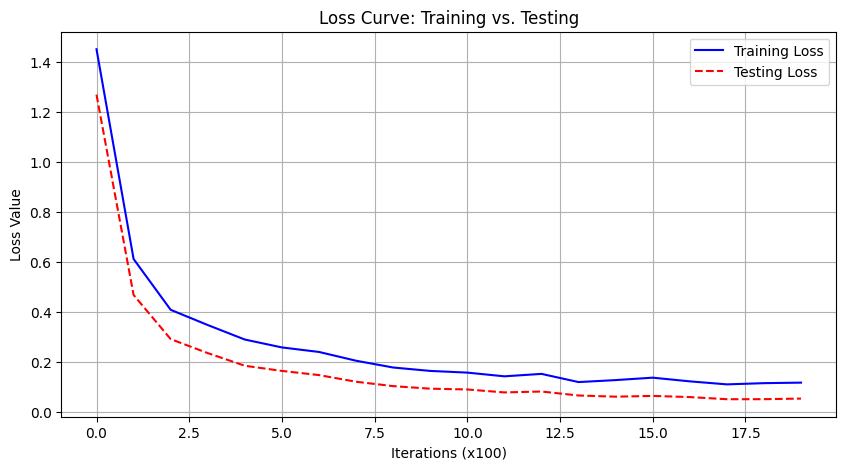

In [21]:
# Plot the recorded loss values
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss", color='blue')
plt.plot(test_loss_history, label="Testing Loss", color='red', linestyle='--')
plt.xlabel("Iterations (x100)")
plt.ylabel("Loss Value")
plt.title("Loss Curve: Training vs. Testing")
plt.legend()
plt.grid(True)
plt.show()

Evaluate results
-------------------

We now vizualize the performance of our model by creating a confusion matrix. The ground truth languages of samples are represented by rows in the matrix while the predicted languages are represented by columns.

In this evaluation we consider sequences of variable sizes rather than the fixed length sequences we used for training.

Test accuracy:  0.848


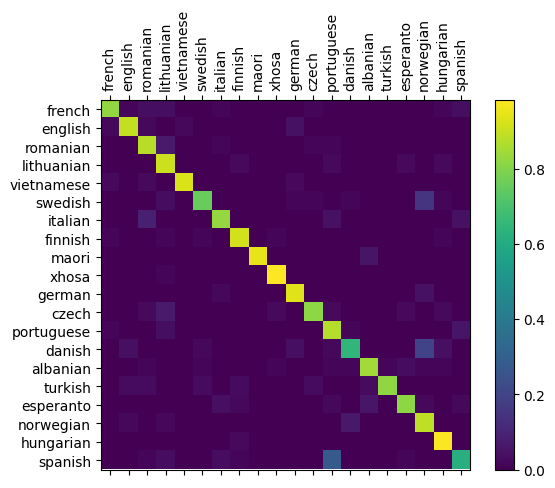

In [22]:
eval_batch_size = 1  # For evaluating different sequence lengths
confusion = torch.zeros(n_languages, n_languages)
n_confusion = 1000
num_correct = 0
total = 0

for i in range(n_confusion):
    eval_chunk_len = random.randint(10, 50)
    input_data, target_category, text_data = load_random_batch(test_category_data, chunk_len=eval_chunk_len, batch_size=eval_batch_size, device=device)
    output = evaluate(rnn, input_data, seq_len=eval_chunk_len, batch_size=eval_batch_size)

    guess_i = categoryFromOutput(output)
    category_i = [int(target_category[idx]) for idx in range(len(target_category))]
    for j in range(eval_batch_size):
        category = all_categories[category_i[j]]
        confusion[category_i[j]][guess_i[j]] += 1
        num_correct += int(guess_i[j] == category_i[j])
        total += 1

print('Test accuracy: ', float(num_correct) / float(n_confusion * eval_batch_size))

# Normalize confusion matrix
for i in range(n_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

# Plot confusion matrix
import matplotlib.ticker as ticker

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes with fixed ticks
ax.set_xticks(range(n_languages))
ax.set_yticks(range(n_languages))
ax.set_xticklabels(all_categories, rotation=90)
ax.set_yticklabels(all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()




You can pick out bright spots off the main axis that show which
languages it guesses incorrectly.




Run on User Input
---------------------

Now you can test your model on your own input.


In [23]:
def predict(input_line, n_predictions=5, seq_len=chunk_len):
    print('\n> %s' % input_line)

    # Normalize the input text
    input_line = unicodeToAscii(input_line.lower().strip())

    # Pad or truncate the input to match `seq_len`
    if len(input_line) < seq_len:
        input_line += " " * (seq_len - len(input_line))
    else:
        input_line = input_line[:seq_len]

    with torch.no_grad():
        # Convert input string to tensor
        input_data = stringToTensor(input_line).long().unsqueeze(0).to(device)

        # Evaluate the input data using the model
        output = evaluate(rnn, input_data, seq_len=seq_len, batch_size=1)

    # Get the top N predictions
    topv, topi = output.topk(n_predictions, dim=1)
    predictions = []

    print("Predictions:")
    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        language = all_categories[category_index]
        print(f"({value:.2f}) {language}")
        predictions.append([value, language])

    return predictions

# Example test cases
predict("This is a test sentence for language prediction", seq_len=30)
predict("Bonjour, comment allez-vous aujourd'hui?", seq_len=30)
predict("Hola, ¿cómo estás?", seq_len=30)
predict("Ciao, come stai?", seq_len=30)



> This is a test sentence for language prediction
Predictions:
(9.62) english
(4.10) french
(1.86) spanish
(1.43) vietnamese
(1.01) albanian

> Bonjour, comment allez-vous aujourd'hui?
Predictions:
(10.95) french
(3.20) portuguese
(2.66) german
(1.88) english
(1.66) romanian

> Hola, ¿cómo estás?
Predictions:
(5.00) esperanto
(3.38) spanish
(2.57) swedish
(2.33) vietnamese
(2.16) norwegian

> Ciao, come stai?
Predictions:
(4.90) romanian
(4.78) vietnamese
(3.25) esperanto
(1.40) portuguese
(1.21) czech


[[4.899930000305176, 'romanian'],
 [4.78359842300415, 'vietnamese'],
 [3.2505075931549072, 'esperanto'],
 [1.3968174457550049, 'portuguese'],
 [1.2076321840286255, 'czech']]

# Output Kaggle submission file

Once you have found a good set of hyperparameters submit the output of your model on the Kaggle test file.

In [24]:
### DO NOT CHANGE KAGGLE SUBMISSION CODE ####
import csv

kaggle_test_file_path = 'language_data/kaggle_rnn_language_classification_test.txt'
with open(kaggle_test_file_path, 'r') as f:
    lines = f.readlines()

output_rows = []
for i, line in enumerate(lines):
    sample = line.rstrip()
    sample_chunk_len = len(sample)
    input_data = stringToTensor(sample).unsqueeze(0)
    output = evaluate(rnn, input_data, seq_len=sample_chunk_len, batch_size=1)
    guess_i = categoryFromOutput(output)
    output_rows.append((str(i+1), all_categories[guess_i]))

submission_file_path = 'kaggle_rnn_submission.csv'
with open(submission_file_path, 'w') as f:
    output_rows = [('id', 'category')] + output_rows
    writer = csv.writer(f)
    writer.writerows(output_rows)
